# MCMC for linear regression

Implementations of Gibbs sampling, Metropolis-Hastings, Hamiltonian Monte Carlo and Metropolis-adjusted Langevin algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

## Experiment configurations

In [2]:
class Config:
    
    def __init__(self):
        
        ### Dataset specifications ###
        
        # True weight(s)
        self.w = np.array([1.5, -1.0, 0.7])

        # Input dimensionality
        self.d = self.w.size

        # True intercept
        self.b = 0.5

        # True standard deviation
        self.sigma = 0.5

        # Number of data points
        self.N = 100

        # Defines range of inputs x
        self.design_range = (-1.0, 1.0)
        
        ### Priors ###
        
        self.beta0 = np.zeros(self.d+1)
        
        # Standard deviation of weight prior
        self.sigma_0 = 100
        
        # Shape parameter of noise prior
        self.a0 = 0.001
        
        # Rate parameter of noise prior
        self.b0 = 0.001
        
        ### MH parameters ###
        
        # Variance of MH proposal distribution
        self.proposal_variance = 0.001
        
        ### HMC parameters ###
        
        # Step size
        self.epsilon = 0.01

        # Number of steps in the proposal
        self.L = 20

        # Mass parameter
        self.m = 1.0
        
        ### MALA parameters ###
        
        # Preconditioner matrix
        self.M = np.identity(self.d + 1)
        
        # Step size for Euler-Maruyama
        self.delta_t = 0.001
        
        ### Common MCMC parameters ###
        
        # beta initialization
        self.beta = np.zeros(self.d+1)
        
        # sigma2 initialization
        self.sigma2 = 1.0
        
        # Length of the chain
        self.chain_length = 10000
        
        # Number of discarded samples from beginning
        self.burn_in = 5000

## Generating data

In [3]:
class Simulator:
    
    def __init__(self, config):
        self.w = config.w
        self.b = config.b
        self.theta = np.expand_dims(np.concatenate([self.w, [self.b]], axis=0), axis=1)
        self.sigma = config.sigma
        self.N = config.N
        self.design_range = config.design_range
        self.X = None
        self.y = None
        self.y_mean = None
        
    def run(self):
        designs = np.random.uniform(self.design_range[0], self.design_range[1], size=(self.N, self.w.size))
        self.X = np.concatenate([designs, np.ones((self.N, 1))], axis=1)
        #print("shape self x", self.X.shape)
        self.y_mean = (self.X @ self.theta).squeeze()
        self.y = np.random.multivariate_normal(mean=self.y_mean, cov=np.diag([self.sigma**2] * self.N))
    
    def plot(self):
        x = self.X[:, 0]
        plt.scatter(x, self.y, label="data")
        x_dense = np.linspace(self.design_range[0], self.design_range[1], 100)
        y_dense = x_dense * self.w[0] + self.b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(self.N))
        plt.show()
        
def create_dataset(config, plot=False):
    simulator = Simulator(config)
    simulator.run()
    if plot:
        simulator.plot()
        
    return simulator.X, simulator.y, simulator.y_mean

## Helper classes and functions

In [4]:
# Helper function for constructing potential energy function
def create_U(X, y, sigma_0):
    
    def U(theta, tau):
        z = y - X @ theta
        return 0.5 * (tau * z.T @ z + theta.T @ theta / (sigma_0 ** 2))
    
    return U

# Helper function for constructing gradient of potential energy function
def create_grad_U(X, y, sigma_0):
    
    def grad_U(theta, tau):
        return tau * (X.T @ X @ theta - X.T @ y) + (theta / (sigma_0 ** 2))
    
    return grad_U


# Helper class for numerically integrating Hamiltonian system
class ODESolver:
    
    def __init__(self, grad_U, epsilon, L, m):
        self.grad_U = grad_U
        self.epsilon = epsilon
        self.L = L
        self.m = m
        
    def dq(self, p):
        return p / self.m
    
    def euler(self, q, p, tau):
        for i in range(self.L):
            p_new = p - epsilon * self.grad_U(q, tau)
            q = q + self.epsilon * self.dq(p)
            p = p_new
        return q, p
    
    def modified_euler(self, q, p, tau):
        for i in range(self.L):
            p = p - self.epsilon * self.grad_U(q, tau)
            q = q + self.epsilon * self.dq(p)
        return q, p
    
    def leapfrog(self, q, p, tau):
        p = p - self.epsilon * self.grad_U(q, tau) / 2
        for i in range(self.L):
            q = q + self.epsilon * self.dq(p)
            if i != self.L - 1:
                p = p - self.epsilon * self.grad_U(q, tau)
        p = p - self.epsilon * self.grad_U(q, tau) / 2
        p = -p
        return q, p
    

# p(beta | X, y sigma2)
def LOGPOST(beta, X, y, sigma2, beta0, Sigma2_0):
    log_likelihood = (-0.5 * (y.T - X @ beta) @ (y.T - X @ beta).T / sigma2).squeeze()
    log_prior_beta = (-0.5 * (beta - beta0).reshape(1, -1) @ np.linalg.inv(Sigma2_0) @ (beta - beta0).reshape(-1, 1)).squeeze()
    return log_likelihood + log_prior_beta

#Work in log form for numeric stability
def ACCPT(beta_new, beta_old, x, y, sigma2, beta0, Sigma2_0):
    PN = LOGPOST(beta_new, x, y, sigma2, beta0, Sigma2_0)
    PO = LOGPOST(beta_old, x, y, sigma2, beta0, Sigma2_0)
    logratio = PN - PO
    ratio = np.exp(logratio)
    return min(1, ratio)

## Main algorithm

In [5]:
class MCMC:
    
    def __init__(self, config, X, y, y_mean, method):
        
        self.config = config
        self.X = X
        self.y = y
        self.y_mean = y_mean
        
        # Create helper functions
        self.U = create_U(X=self.X, y=self.y, sigma_0=config.sigma_0)
        self.grad_U = create_grad_U(X=self.X, y=self.y, sigma_0=config.sigma_0)
        self.solver = ODESolver(self.grad_U, config.epsilon, config.L, config.m)
        
        self.Sigma2_0 = config.sigma_0 ** 2 * np.identity(config.d+1)
        
        self.method = method
        
    def sample_sigma2(self, beta, simulator=None):
        alpha = self.config.a0 + self.config.N / 2
        if simulator==None:
            #print(self.X.shape, beta.shape)
            z = self.y - self.X @ beta
        else:
            z = simulator.y - simulator.X @ beta
        beta = self.config.b0 + 0.5 * z.T @ z
        sigma2 = 1 / np.random.gamma(alpha, 1 / beta)
        return sigma2
    
    def gibbs_step(self, sigma2):

        # Compute the parameters for the normal distribution from which we sample beta
        A = (self.X.T @ self.X)/ sigma2 + np.linalg.inv(self.Sigma2_0)
        b = (self.X.T @ self.y) / sigma2 + np.linalg.inv(self.Sigma2_0) @ self.config.beta0
        mu = np.linalg.solve(A, b)
        Sigma = np.linalg.inv(A)

        # Sample beta
        beta = np.random.multivariate_normal(mu, Sigma)
        
        return beta, 1
    
    def MH_step(self, beta_old, sigma2, simulator=None):
        
        if simulator==None:
            simulator = self.config
            
        proposal_cov = np.identity((simulator.d + 1)) * self.config.proposal_variance
        beta_new = np.random.multivariate_normal(mean=beta_old, cov=proposal_cov) 
        #print("self x shape mh step", self.X.shape, self.config.beta0)
        alpha = ACCPT(beta_new, beta_old, self.X, self.y, sigma2, self.config.beta0, self.Sigma2_0)
        u = np.random.rand()
        if u < alpha:
            return beta_new, 1
        else:
            return beta_old, 0
            
    def HMC_step(self, q, sigma2, simulator=None):
        
        if simulator==None:
            simulator = self.config
            
        p = np.random.multivariate_normal(np.zeros(simulator.d + 1), np.diag([1] * (self.config.d + 1)))
        q_proposed, p_proposed = self.solver.leapfrog(q, p, 1/sigma2)
        U = self.U(q, 1/sigma2)
        K = ((p ** 2) / (2 * self.config.m)).sum()
        U_proposed = self.U(q_proposed, 1 / sigma2)
        K_proposed = ((p_proposed ** 2) / (2 * self.config.m)).sum()
        u = np.random.uniform()
        if u < np.exp(U - U_proposed + K - K_proposed):
            return q_proposed, 1
        else:
            return q, 0
    
    def MALA_step(self, beta_old, sigma2, simulator=None):
        
        if simulator==None:
            A = (self.X.T @ self.X)/ sigma2 + np.linalg.inv(self.Sigma2_0)
            b = (self.X.T @ self.y) / sigma2 + np.linalg.inv(self.Sigma2_0) @ self.config.beta0
        else:
            A = (simulator.X.T @ simulator.X)/ sigma2 + np.linalg.inv(self.Sigma2_0)
            b = (simulator.X.T @ simulator.y) / sigma2 + np.linalg.inv(self.Sigma2_0) @ self.config.beta0
        
        mu = np.linalg.solve(A, b)
        Sigma = np.linalg.inv(A)
        
        grad = -A @ (beta_old - mu)
        
        proposal_mean = beta_old + 0.5 * self.config.delta_t * self.config.M @ grad
        proposal_cov = self.config.M * self.config.delta_t
        
        beta_proposed = np.random.multivariate_normal(mean=proposal_mean, cov=proposal_cov)
        
        PN = LOGPOST(beta_proposed, self.X, self.y, sigma2, self.config.beta0, self.Sigma2_0)
        PO = LOGPOST(beta_old, self.X, self.y, sigma2, self.config.beta0, self.Sigma2_0)
        
        proposal_density = mvn.pdf(beta_proposed, proposal_mean, proposal_cov)
        
        reverse_proposal_mean = beta_proposed + 0.5 * self.config.delta_t * self.config.M @ grad
        
        reverse_proposal_density = mvn.pdf(beta_old, reverse_proposal_mean, proposal_cov)
        
        acceptance_ratio = np.exp(PN + np.log(reverse_proposal_density) - PO - np.log(proposal_density))
        
        u = np.random.uniform()
        if u < acceptance_ratio:
            return beta_proposed, 1
        else:
            return beta_old, 0
    
    def run(self, simulator=None):
            
        num_samples = self.config.chain_length - self.config.burn_in
        if simulator==None:
            self.samples = np.zeros((num_samples, self.config.d + 2))
        else:
            self.samples = np.zeros((num_samples, simulator.d + 2))
        acceptances = []
        
        # Initialize chain
        if simulator==None:
            beta = self.config.beta
        else:
            beta = simulator.beta
        
        sigma2 = self.config.beta0
        
        for i in range(self.config.chain_length):
            if simulator==None:
                sigma2 = self.sample_sigma2(beta)
            else:
                sigma2 = self.sample_sigma2(beta, simulator)
            
            if self.method == "Gibbs":
                beta, acceptance = self.gibbs_step(sigma2)
                
            elif self.method == "MH":
                if simulator==None:
                    beta, acceptance = self.MH_step(beta, sigma2)
                else:
                    beta, acceptance = self.MH_step(beta, sigma2, simulator)
                
            elif self.method == "HMC":
                if simulator==None:
                    beta, acceptance = self.HMC_step(beta, sigma2)
                else:
                    beta, acceptance = self.HMC_step(beta, sigma2, simulator)
                
            elif self.method == "MALA":
                beta, acceptance = self.MALA_step(beta, sigma2)
            
            else:
                raise NotImplementedError("Method must be Gibbs, MH, HMC or MALA")
            
            if i >= self.config.burn_in:
                j = i - self.config.burn_in
                self.samples[j, 0] = np.sqrt(sigma2)
                self.samples[j, 1:] = beta
                acceptances.append(acceptance)
                
        acceptance_rate = np.array(acceptances).mean()
        
        return self.samples, acceptance_rate
    
    def plot(self, simulator=None):
        
        if simulator==None:
            simulator = self.config
        
        true_params = np.concatenate([[simulator.sigma], simulator.w, [simulator.b]], axis=0)
        
        num_params = self.config.d + 2
        plt.figure(figsize=(15, 5 * num_params))
        param_names = ["sigma"]
        
        for i in range(num_params - 2):
            param_names.append("weight " + str(i+1))
        param_names.append("intercept")
        
        for i in range(num_params):
            true_val = true_params[i]
            samples = self.samples[:, i]
            plt.subplot(num_params,2,i*2+1)
            y, _, _ = plt.hist(samples, bins=100, label="samples")
            max_y = int(np.max(y))
            plt.plot([true_val] * max_y, range(max_y), c="r", label="true value")
            plt.title("Histogram for {}".format(param_names[i]))
            plt.legend()
            plt.subplot(num_params,2,i*2+2)
            plt.plot(samples, label="chain")
            plt.plot([0, samples.size], [true_val, true_val], c="r", label="true value")
            plt.title("Trace plot for {}".format(param_names[i]))
            plt.legend()
            
        plt.show()
        
    def evaluate(self, test_simulator):
        
        "Computes MSE between test data and the predictions of the model"

        test_covariates = test_simulator.X
        mean_weights = self.samples.mean(axis=0)[1:]
        #print(test_covariates.shape, mean_weights.shape, self.samples.shape)
        predictions = test_covariates @ mean_weights
        mse = ((predictions - test_simulator.y) ** 2).mean()
        return mse


In [6]:
#config = Config()
#X, y, y_mean = create_dataset(config)

In [7]:
#chain = MCMC(config, X, y, y_mean, method="Gibbs")
#samples, acceptance_rate = chain.run()
#print(f"Acceptance rate: {acceptance_rate}")
#chain.plot()

In [8]:
#chain.method = "MH"
#samples, acceptance_rate = chain.run()
#print(f"Acceptance rate: {acceptance_rate}")
#chain.plot()

In [9]:
'''chain.method = "HMC"
samples, acceptance_rate = chain.run()
print(f"Acceptance rate: {acceptance_rate}")
chain.plot()'''

'chain.method = "HMC"\nsamples, acceptance_rate = chain.run()\nprint(f"Acceptance rate: {acceptance_rate}")\nchain.plot()'

In [10]:
'''chain.method = "MALA"
samples, acceptance_rate = chain.run()
print(f"Acceptance rate: {acceptance_rate}")
chain.plot()'''

'chain.method = "MALA"\nsamples, acceptance_rate = chain.run()\nprint(f"Acceptance rate: {acceptance_rate}")\nchain.plot()'

# Diagnostic
## Run experiments for univariate and multivariate linear regression for algorithms
Compute MSE on test data for 5 random seeds.

### 1. Univariate

In [11]:
# Helper function for constructing conditional distribution for tau
def create_p_tau(X, y, alpha_0, beta_0, N):
    alpha = alpha_0 + N / 2
    
    def p_tau(tau, theta):
        z = y - X @ theta
        beta = beta_0 + 0.5 * z.T @ z
        return np.random.gamma(alpha, 1 / beta)
    
    return p_tau

In [12]:
# Define true parameters
w = np.array([1.5]) # weight
b = 0.7 # intercept
sigma = 0.5 # noise standard deviation
N = 100  # number of data points
design_range = (-1.0, 1.0) # range of covariates
d = w.size # Number of covariates
theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
beta = np.zeros(d+1)
beta0 = np.zeros(d+1)
M = np.identity(d + 1)

#simulator.run()

# Initialize chain
theta = np.zeros(2)
tau = 1.0

In [13]:
def calculate_MSE_univariate(method):
    
    MSE_univariate = [] # Store all the MSE values
    
    config = Config()
    config.w, config.b, config.sigma, config.N, config.design_range, config.d, config.theta, config.beta, config.beta0, config.M = w, b, sigma, N, design_range, d, theta, beta, beta0, M

    for _ in range(0,5):

        # Replace simulator with true parameters
        simulator = Simulator(config)
        simulator.w, simulator.b, simulator.sigma, simulator.N, simulator.design_range, simulator.d, simulator.theta, simulator.beta, simulator.beta0 = w, b, sigma, N, design_range, d, theta, beta, beta0
        simulator.run()

        # Create helper functions based on data
        U = create_U(X=simulator.X, y=simulator.y, sigma_0=config.sigma_0)
        grad_U = create_grad_U(X=simulator.X, y=simulator.y, sigma_0=config.sigma_0)
        p_tau = create_p_tau(X=simulator.X, y=simulator.y, alpha_0=config.a0, beta_0=config.b0, N=simulator.N)
        solver = ODESolver(grad_U, config.epsilon, config.L, config.m)

        # Run chain
        chain = MCMC(config, simulator.X, simulator.y, simulator.y_mean, method=method)

        if method == "HMC":
            chain.method == "HMC"
            samples, acceptance_rate = chain.run()

        elif method == "Gibbs":
            chain.method == "Gibbs"
            samples, acceptance_rate = chain.run()

        elif method == "MH":
            chain.method == "MH"
            samples, acceptance_rate = chain.run()

        elif method == "MALA":
            chain.method == "MALA"
            samples, acceptance_rate = chain.run()

        else:
            raise NotImplementedError("Method must be Gibbs, MH, HMC or MALA")

        posterior_mean = samples.mean(axis=0)

        # Plot estimated model
        x_axis = np.linspace(design_range[0], design_range[1], 100)
        y_pred = x_axis * posterior_mean[1] + posterior_mean[2]
        y_true = x_axis * w + b
        #print(w,b, posterior_mean[1], posterior_mean[2])

        # Simulate test data
        config = Config()
        config.w, config.b, config.sigma, config.N, config.design_range, config.d, config.theta, config.beta, config.beta0, config.M = w, b, sigma, N, design_range, d, theta, beta, beta0,M

        test_simulator = Simulator(config)
        test_simulator.w, test_simulator.b, test_simulator.sigma, test_simulator.N, test_simulator.design_range, test_simulator.d, test_simulator.theta, test_simulator.beta, test_simulator.beta0 = w, b, sigma, N, design_range, d, theta, beta, beta0
        #print(test_simulator.w)
        test_simulator.run()
        test_mse = chain.evaluate(test_simulator)
        MSE_univariate.append(test_mse)
        print("Test MSE: {}".format(test_mse))
    
    print("Mean of MSE: {}".format(np.mean(MSE_univariate)))
    print("Standard Deviation of MSE: {}".format(np.std(MSE_univariate)))
    
    plt.plot(x_axis, y_pred, label="prediction")
    plt.plot(x_axis, y_true, label="truth")
    plt.scatter(simulator.X[:, 0], simulator.y, label="data")
    plt.legend()
    plt.title(f"Evaluation of the fit of {method}")
    plt.show()

[1.5] 0.7 0.07573012033863963 -0.05955764684950956
Test MSE: 0.2617219645330317
[1.5] 0.7 -0.021615458246142735 -0.019521768330174365
Test MSE: 0.23457023940443958
[1.5] 0.7 0.060841577746672246 -0.0026128130851720273
Test MSE: 0.19975014362908086
[1.5] 0.7 0.13616268703286374 -0.03625484977140631
Test MSE: 0.2213053380088171
[1.5] 0.7 0.17936727176676315 0.09011580175799225
Test MSE: 0.2664424501819303
Mean of MSE: 0.2367580271514599
Standard Deviation of MSE: 0.024970056467753916


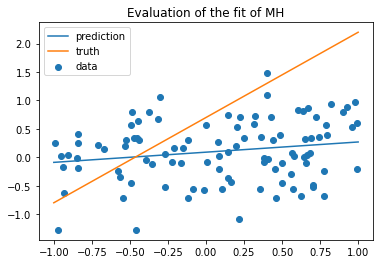

In [14]:
calculate_MSE_univariate("MH")

[1.5] 0.7 -0.052243842874832795 -0.11312793327175306
Test MSE: 0.2451709636459319
[1.5] 0.7 -0.0025695117951172086 0.07513800929081735
Test MSE: 0.31616450948053865
[1.5] 0.7 0.05313641651586255 -0.020696037759122567
Test MSE: 0.22723975592631976
[1.5] 0.7 -0.009718989163274922 -0.006733547374346844
Test MSE: 0.20615327870161032
[1.5] 0.7 0.10490568442251333 0.06157494167290131
Test MSE: 0.2229475697822216
Mean of MSE: 0.24353521550732443
Standard Deviation of MSE: 0.03837835945901136


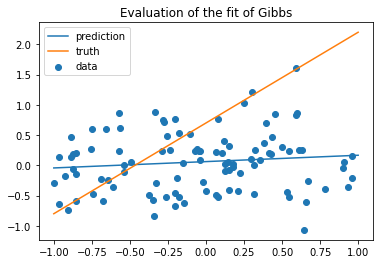

In [15]:
calculate_MSE_univariate("Gibbs")

[1.5] 0.7 0.01943943817274275 0.11746388266020653
Test MSE: 0.27812758110164576
[1.5] 0.7 0.01573735020707663 -0.033111272151161046
Test MSE: 0.20875239506035942
[1.5] 0.7 0.07099646262036072 -0.07248832423821455
Test MSE: 0.3218831638737942
[1.5] 0.7 0.08519005983463109 -0.02863957474733557
Test MSE: 0.27495232665921177
[1.5] 0.7 -0.1324133793939479 0.028247043858575075
Test MSE: 0.3131095053286221
Mean of MSE: 0.2793649944047266
Standard Deviation of MSE: 0.03988390343729241


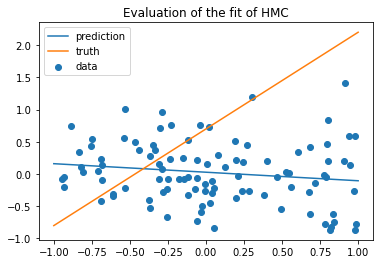

In [16]:
calculate_MSE_univariate("HMC")

[1.5] 0.7 -0.03600146249830587 0.062382995067207125
Test MSE: 0.2896890649401047
[1.5] 0.7 -0.032870981402306584 -0.05639791990593478
Test MSE: 0.3094190484600856
[1.5] 0.7 -0.09890324501148604 -0.011911629229562272
Test MSE: 0.18928189318129918
[1.5] 0.7 -0.08722931459594879 -0.027067613907391666
Test MSE: 0.24708269162376215
[1.5] 0.7 -0.01396371997186933 0.07711646950770194
Test MSE: 0.23635638913397033
Mean of MSE: 0.25436581746784437
Standard Deviation of MSE: 0.042170820922012055


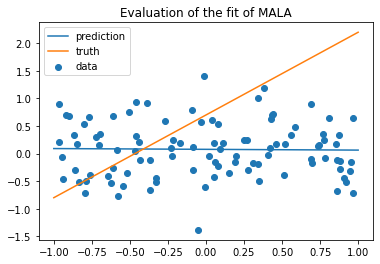

In [17]:
calculate_MSE_univariate("MALA")

### 2. Multivariate

In [21]:
# Define true parameters
w = np.random.normal(0, 1, size=30) # sample weights
b = np.random.normal(0, 1) # sample intercept
sigma = 0.5 # noise standard deviation
N = 100  # number of data points
design_range = (-1.0, 1.0) # range of covariates
d = w.size # Number of covariates

theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
beta = np.zeros(d+1)
beta0 = np.zeros(d+1)
M = np.identity(d + 1)

# Initialize chain
theta = np.zeros(d+1)
tau = 1.0

In [32]:
def calculate_MSE_multivariate(method):
    
    MSE_multivariate = [] # Store all the MSE values
    
    config = Config()
    config.w, config.b, config.sigma, config.N, config.design_range, config.d, config.theta, config.beta, config.beta0, config.M = w, b, sigma, N, design_range, d, theta, beta, beta0, M

    
    for _ in range(0,5):
    
        simulator = Simulator(config)
        simulator.w, simulator.b, simulator.sigma, simulator.N, simulator.design_range, simulator.d, simulator.theta, simulator.beta = w, b, sigma, N, design_range, d, theta, beta
        simulator.run()

        # Create helper functions based on data
        U = create_U(X=simulator.X, y=simulator.y, sigma_0=config.sigma_0)
        grad_U = create_grad_U(X=simulator.X, y=simulator.y, sigma_0=config.sigma_0)
        p_tau = create_p_tau(X=simulator.X, y=simulator.y, alpha_0=config.a0, beta_0=config.b0, N=simulator.N)

        solver = ODESolver(grad_U, config.epsilon, config.L, config.m)

        # Run chain
        chain = MCMC(config, simulator.X, simulator.y, simulator.y_mean, method=method)
        
        if method == "HMC":
            chain.method == "HMC"
            samples, acceptance_rate = chain.run(simulator)

        elif method == "Gibbs":
            chain.method == "Gibbs"
            samples, acceptance_rate = chain.run(simulator)

        elif method == "MH":
            chain.method == "MH"
            samples, acceptance_rate = chain.run(simulator)

        elif method == "MALA":
            chain.method == "MALA"
            samples, acceptance_rate = chain.run(simulator)

        else:
            raise NotImplementedError("Method must be Gibbs, MH, HMC or MALA")

        true_params = np.concatenate([[sigma], w, [b]], axis=0)
        
        if _ == 4:
            chain.plot()

        config = Config()
        config.w, config.b, config.sigma, config.N, config.design_range, config.d, config.theta, config.beta, config.beta0, config.M = w, b, sigma, N, design_range, d, theta, beta, beta0, M

        # Run test simulator
        test_simulator = Simulator(config)
        test_simulator.w, test_simulator.b, test_simulator.sigma, test_simulator.N, test_simulator.design_range, test_simulator.d, test_simulator.theta, test_simulator.beta, test_simulator.beta0 = w, b, sigma, N, design_range, d, theta, beta, beta0
        test_simulator.run()
        test_mse = chain.evaluate(test_simulator)
        MSE_multivariate.append(test_mse)
        #print("Test MSE: {}".format(test_mse))
    
    print("Mean of MSE: {}".format(np.mean(MSE_multivariate)))
    print("Standard Deviation of MSE: {}".format(np.std(MSE_multivariate)))


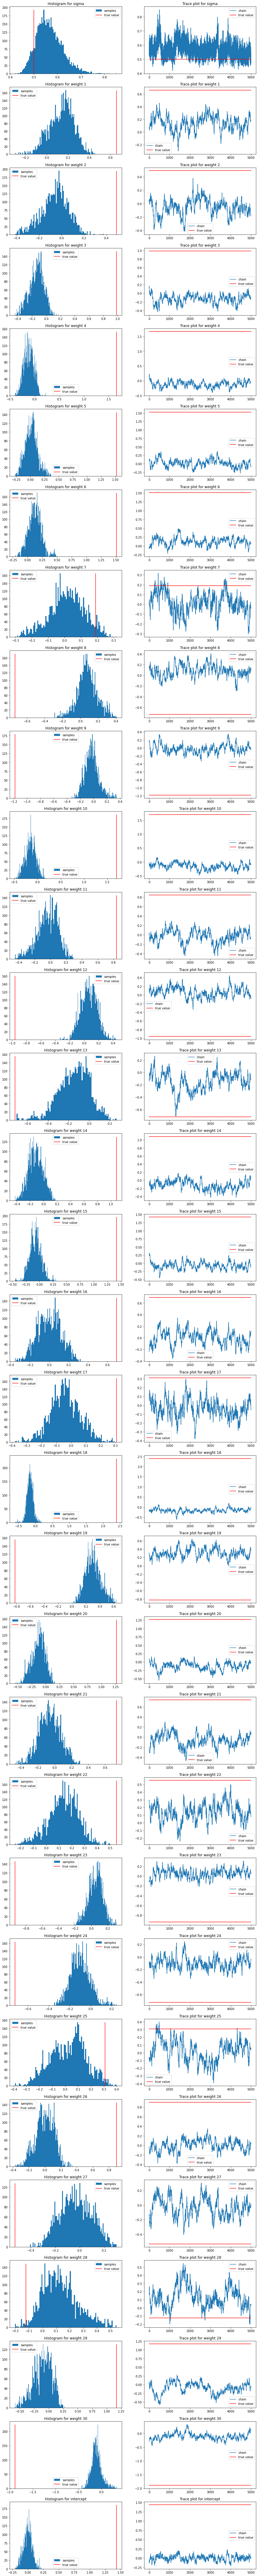

Mean of MSE: 0.36807063301407544
Standard Deviation of MSE: 0.047558207029153206


In [33]:
calculate_MSE_multivariate("MH")

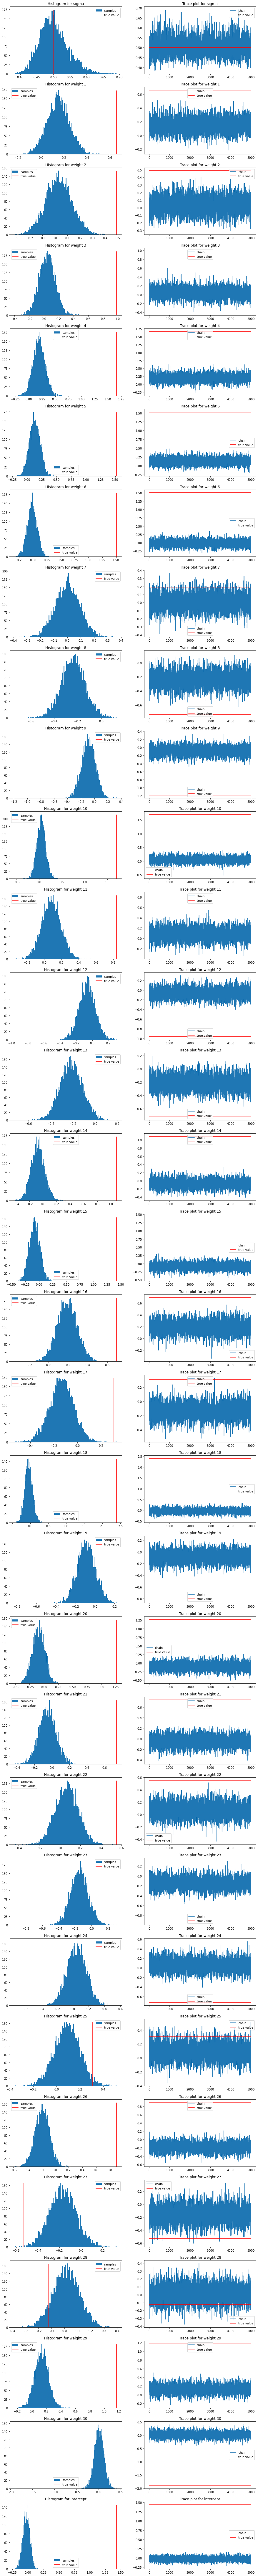

Mean of MSE: 0.32660410846437404
Standard Deviation of MSE: 0.028715515179426096


In [34]:
calculate_MSE_multivariate("Gibbs")

In [ ]:
calculate_MSE_multivariate("HMC")

In [ ]:
calculate_MSE_multivariate("MALA")